In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.optimizer_v2 import rmsprop, adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import batch_normalization
from keras.models import Model

In [23]:
img_rows, img_cols = 150, 150

DenseNet201 = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape = (img_rows, img_cols, 3))
for layer in DenseNet201.layers:
    layer.trainable = False

In [24]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [25]:
num_classes = 5

FC_Head = lw(DenseNet201, num_classes)

model = Model(inputs = DenseNet201.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                            

In [26]:
train_generator = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Program Hama Cabai/chili-plant-disease/Train',
                                                image_size=(150, 150),
                                                batch_size=32,
                                                label_mode='categorical',)

 
validation_generator = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Program Hama Cabai/chili-plant-disease/Test',
                                            image_size=(150, 150),
                                            batch_size=32,
                                            label_mode='categorical')


Found 400 files belonging to 5 classes.
Found 180 files belonging to 5 classes.


In [27]:
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/Program Hama Cabai/Model_Densenet201.h5",
                             monitor="val_loss",
                             save_best_only = True,
                             verbose=1,
                             mode = 'auto',
                             save_freq = 'epoch')

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 7,
                          verbose = 1,
                          mode = 'auto')

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

nb_train_samples = 400
nb_validation_samples = 180
 
history = model.fit(x=train_generator, validation_data = validation_generator, epochs = 100, callbacks = callbacks)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 7.1670 - accuracy: 0.3200
Epoch 1: val_loss improved from inf to 1.50813, saving model to /content/gdrive/MyDrive/Program Hama Cabai/Model_Densenet201.h5
13/13 [==============================] - 19s 560ms/step - loss: 7.1670 - accuracy: 0.3200 - val_loss: 1.5081 - val_accuracy: 0.4556
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 1.3615 - accuracy: 0.5225
Epoch 2: val_loss improved from 1.50813 to 0.91467, saving model to /content/gdrive/MyDrive/Program Hama Cabai/Model_Densenet201.h5
13/13 [==============================] - 4s 303ms/step - loss: 1.3615 - accuracy: 0.5225 - val_loss: 0.9147 - val_accuracy: 0.6333
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.6825
Epoch 3: val_loss improved from 0.91467 to 0.65180, saving model to /content/gdrive/MyDrive/Program Hama Cabai/Model_Densenet201.h5
13/13 [==============================] - 4s 301ms/step - los

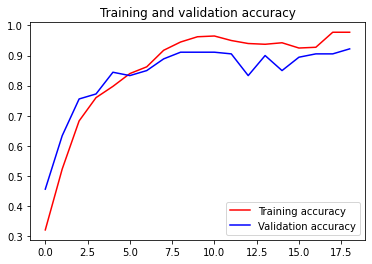

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

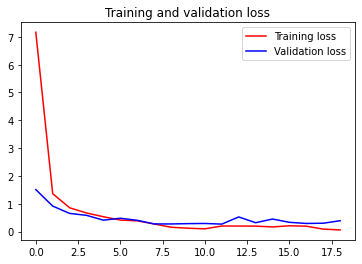

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [40]:
score= model.evaluate(train_generator, verbose=0)
val_score= model.evaluate(validation_generator, verbose=0)
print('Test Loss:', val_score1[0])
print('Test Accuracy:', val_score1[1])

Test Loss: 0.38759422302246094
Test Accuracy: 0.9222221970558167


In [30]:
val_samples = sum([y.shape[0] for [_, y] in validation_generator])
val_samples

180

In [31]:
def pred(model):
    y_val = []
    y_val_pred = []
    for images, targets in validation_generator:
        for image, target in zip(images, targets):
            img_array = image.numpy().astype("uint8")
            prediction = model.predict(np.array([img_array]))
            y_val_pred.append(np.argmax(prediction))
            y_val.append(np.argmax(target))
            
    return y_val, y_val_pred

In [32]:
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report

y_val, y_val_pred=pred(model)

print('Confusion Matrix :')
print()
print(confusion_matrix(y_val, y_val_pred))
print()
print()
print('Classification Report :')
print()
print(classification_report(y_val, y_val_pred))

Confusion Matrix :

[[33  3  0  0  0]
 [ 1 35  0  0  0]
 [ 0  1 35  0  0]
 [ 0  2  2 32  0]
 [ 0  3  1  1 31]]


Classification Report :

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        36
           1       0.80      0.97      0.88        36
           2       0.92      0.97      0.95        36
           3       0.97      0.89      0.93        36
           4       1.00      0.86      0.93        36

    accuracy                           0.92       180
   macro avg       0.93      0.92      0.92       180
weighted avg       0.93      0.92      0.92       180



In [33]:
categories1 = os.listdir('/content/gdrive/MyDrive/Program Hama Cabai/chili-plant-disease/Train')
categories2 = os.listdir('/content/gdrive/MyDrive/Program Hama Cabai/chili-plant-disease/Test')

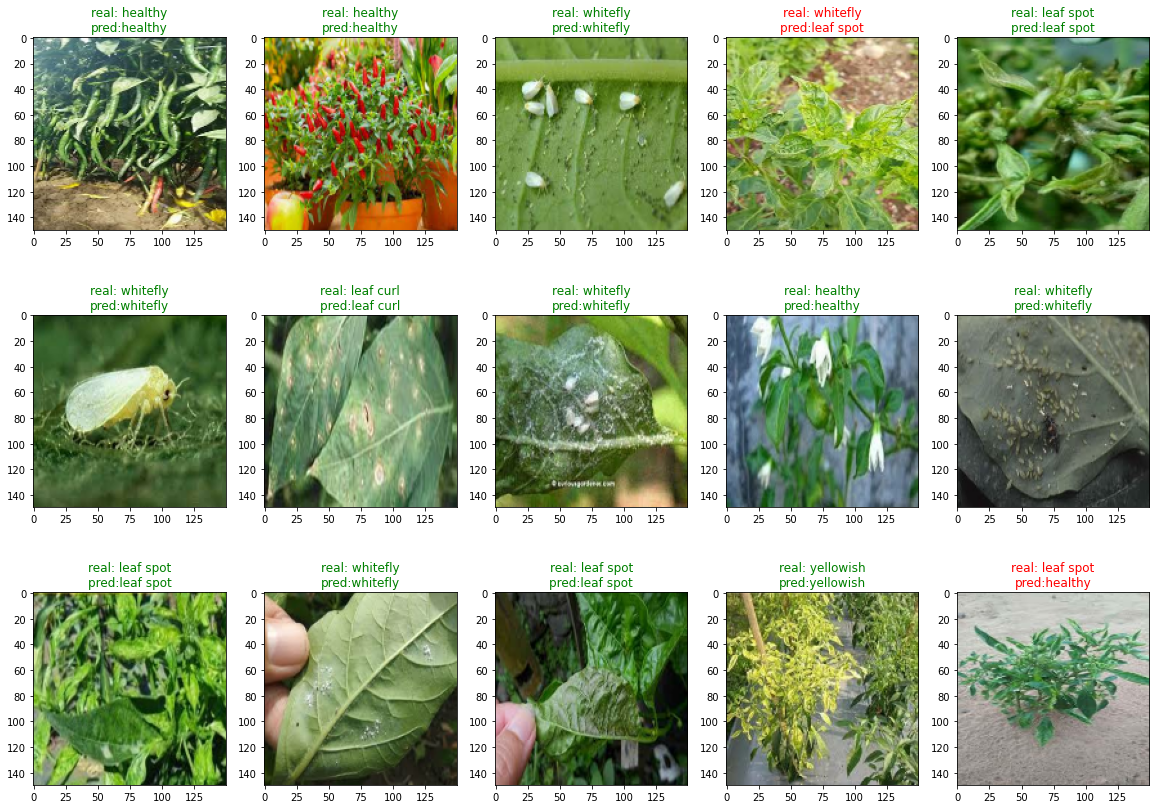

In [34]:
plt.figure(figsize=(20, 40))
for images, labels in validation_generator.take(1):
    for i in range(15):
        ax = plt.subplot(8, 5, i + 1)
        
        img_array = images[i].numpy().astype("uint8")
        prediction = model.predict(np.array([img_array]))
        prediction_name = categories2[np.argmax(prediction)]
        real_name = categories2[np.argmax(labels[i])]
        
        plt.imshow(img_array)
        if prediction_name == real_name:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'g'})
        else:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'r'})